error analysis + log less features 2

In [1]:
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from modules import machine_learning_utils as mlu

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../data_lake/output/train_eng.pkl")
val = pd.read_pickle("../../data_lake/output/val_eng.pkl")

In [4]:
cols = ['card1', 'card2', 'card3','card5','M4', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38','num_transaction_per_time']

In [5]:
df = df.drop(columns=cols)

In [6]:
val = val.drop(columns=cols)

# 2.0 Training baseline

In [7]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [8]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [9]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [10]:
# parameters = {'model__max_depth':[3,6,10],
#               'model__n_estimators':[100,400,800],
#               'model__learning_rate':[0.05,0.01,0.1],
#               'model__min_samples_leaf':[1,3],
#               'model__min_samples_split':[2,4,6]}

In [11]:
# {'model__learning_rate': 0.5, 'model__max_depth': 6, 'model__min_samples_leaf': 3, 'model__n_estimators': 600}

In [12]:
parameters = {'model__max_depth':[6,8],'model__n_estimators':[500,800],'model__learning_rate':[0.05,0.1],'model__min_samples_leaf':[3,5]}

In [13]:
model = mlu.model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.87915758 0.89078492 0.8819401  0.90386593 0.92404796 0.92849121
 0.91881546 0.92288487 0.9127528  0.9127528  0.90262    0.90262
 0.94310833 0.94310833 0.92666503 0.92666503]

Mean CV Scores: 
[0.8275819  0.83032306 0.82558813 0.83480718 0.8340601  0.83480755
 0.83405985 0.8338106  0.83505655 0.83505655 0.83244046 0.83244046
 0.84128581 0.84128581 0.83667489 0.83667489]

Best Parameters: 
{'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}



# 3.0 Evaluation baseline

In [14]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [15]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

In [16]:
m = mlu.model_calibration(model,X_val,y_val)

Test results...
Model Test Recall: 0.8517179023508138
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.85      0.91     19976
         1.0       0.32      0.85      0.47      1659

    accuracy                           0.85     21635
   macro avg       0.65      0.85      0.69     21635
weighted avg       0.93      0.85      0.88     21635

ProductCD: 0.3204076362998419
TransactionAmt: 0.14343000107184956
card4: 0.13104672782140595
P_emaildomain: 0.025223769402368465
addr2: 0.012033488338027181
multi_transaction_per_time: 0.006267940261555033
R_emaildomain: 0.0051341140250081435
device_info_v4: 0.00510613494903186
DeviceType: 0.003658257210281853
max_d: 0.002309863815483917
max_c: 0.0014520695771733966
card6: 0.0010054128432358431
addr1: 3.549110105942713e-05
browser_enc: 2.5990696714438614e-05


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(add_indicator=True,
                                                                                    estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                  random_state=1),
                                                                                    random_state=1)),
                                                                  ('scaler',
                                                                   FunctionTransformer(func=<function log_transform at 0x7f9742a96430>))]),
                                                  Index(['TransactionAmt', 'max_c', 'max_d',...
                                 

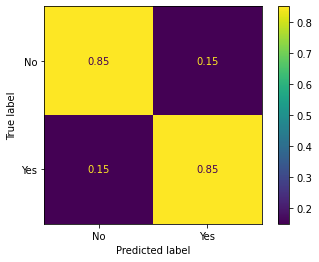

In [17]:
mlu.model_evaluation(m.base_estimator, X_val, y_val)

# 4.0 Error analysis

In [18]:
val.insert(0,'probability_score','')
val['probability_score'] = model.predict_proba(X_val)[:,1]

In [19]:
val.sample(2)

,probability_score,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,max_c,max_d,multi_transaction_per_time,browser_enc,device_info_v4
50382,0.799017,0,125.0,R,american express,credit,204.0,87.0,gmail.com,gmail.com,mobile,4.0,396.000000,0,safari,ios
114970,0.002106,0,50.0,S,american express,credit,184.0,87.0,nan,comcast.net,desktop,1.0,204.041672,0,chrome,windows


In [20]:
er = val[(val['probability_score']<0.5) & (val['isFraud']=='1')]

In [21]:
er.shape

(246, 16)

In [22]:
er.sample(5)

,probability_score,isFraud,TransactionAmt,ProductCD,card4,card6,addr1,addr2,P_emaildomain,R_emaildomain,DeviceType,max_c,max_d,multi_transaction_per_time,browser_enc,device_info_v4
35517,0.023687,1,93.280,C,mastercard,debit,nan,nan,hotmail.com,hotmail.com,mobile,1.0,0.000000,0,chrome,lg
35389,0.024640,1,300.000,R,visa,debit,387.0,87.0,anonymous.com,anonymous.com,desktop,3.0,87.666664,1,edge,windows
40377,0.119411,1,200.000,S,mastercard,credit,204.0,87.0,nan,anonymous.com,desktop,1.0,7.916666,0,edge,windows
109216,0.333311,1,85.796,C,visa,debit,nan,nan,outlook.es,outlook.es,desktop,1.0,259.000000,0,chrome,windows
56334,0.469534,1,39.877,C,visa,debit,nan,nan,hotmail.com,hotmail.com,mobile,4.0,2.000000,0,chrome,other


<AxesSubplot:>

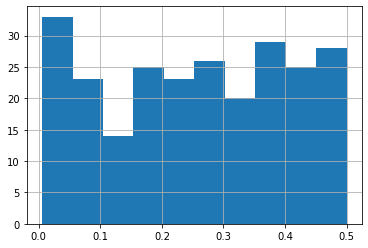

In [23]:
er['probability_score'].hist()

In [24]:
for i in er:
    print(i)
    print(er[i].value_counts(normalize=True).head(5))

probability_score
0.359349    0.008130
0.358691    0.008130
0.227321    0.004065
0.491140    0.004065
0.466972    0.004065
Name: probability_score, dtype: float64
isFraud
1    1.0
Name: isFraud, dtype: float64
TransactionAmt
100.0    0.069106
150.0    0.052846
50.0     0.048780
75.0     0.028455
200.0    0.024390
Name: TransactionAmt, dtype: float64
ProductCD
C    0.666667
H    0.150407
R    0.134146
S    0.048780
Name: ProductCD, dtype: float64
card4
visa                0.560976
mastercard          0.402439
discover            0.020325
american express    0.016260
Name: card4, dtype: float64
card6
debit     0.560976
credit    0.439024
Name: card6, dtype: float64
addr1
nan      0.638211
299.0    0.056911
330.0    0.036585
325.0    0.024390
264.0    0.016260
Name: addr1, dtype: float64
addr2
nan     0.638211
87.0    0.329268
60.0    0.028455
96.0    0.004065
Name: addr2, dtype: float64
P_emaildomain
gmail.com        0.414634
hotmail.com      0.247967
anonymous.com    0.093496
nan       

# 4.0 Model Output

In [15]:
with open('../../data_lake/output/trained_model_v1.pkl','wb') as file:
    pickle.dump(m.base_estimator, file)